## EA run comparisons 2018

Read all experiment data:

In [3]:
import os
import pandas as pd
import glob
import re
import numpy as np

run_directory_prefix = "../models/NarxModelSearch/runs/"
file_name_pattern = "*Runs.csv"
file_name_pattern_extra = "*Runs.csv"
columns = ["datetime", "iteration", "island", "cvMseMean", "cvMseStd", "cvSmapeMean", "cvSmapeStd", "holdoutRmse", "holdoutSmape", "holdoutMape", "holdoutMse", "holdoutIoa", "full_parameters", "holdoutMase"]

columnsExtra = ["timesteps", "swapEvery", "cellular_automata_dimensions", "agents", "folds", "cvMaseMean", "cvMaseStd", "holdoutMase", "mutationProbabilityThreshold", "mutationProbabilities ", "l1_l2_randoms", "elapsedTime", "full_mase", "full_smape", "full_rmse", "full_mae", "full_ioa", "full_mse", "holdout_mae", "holdout_DM_MSE_statistic", "holdout_DM_MSE_p-value", "holdout_DM_MAD_statistic", "holdout_DM_MAD_p-value", "holdout_DM_MAPE_statistic", "holdout_DM_MAPE_p-value", "holdout_DM_poly4_statistic", "holdout_DM_poly4_p-value", "holdout_max_validation_length", "gpu_device"]

experiment_directories = [
                            # "CY_64unitsMax_4islands__1",
                            # "CY_64unitsMax_8islands__1"
                            # "CY_64unitsMax_16islands__1"
                            # "CY_64unitsMax_24islands__1"
                            # "CY_64unitsMax_32islands__1"
                            # "CY_64unitsMax_40islands__1"

                            # "MT_64unitsMax_4islands__1",
                            # "MT_64unitsMax_8islands__1"
                            # "MT_64unitsMax_16islands__1"
                            # "MT_64unitsMax_24islands__1"
                            # "MT_64unitsMax_32islands__1"
                            # "MT_64unitsMax_40islands__1"

                            "MT_64unitsMax_4islands__2",
                            # "MT_64unitsMax_8islands__2"
                            # "MT_64unitsMax_16islands__2"
                            # "MT_64unitsMax_24islands__2"
                            # "MT_64unitsMax_32islands__2"
                            # "MT_64unitsMax_40islands__2"
                         ]

run_directories = []
for experiment_directory in experiment_directories:
    new_run_directory = run_directory_prefix + experiment_directory + "/"
#     print("new_run_directory:", new_run_directory)
    run_directories.append(new_run_directory)

# worker_directories = ["local", "TX2"]
worker_directories = ["local", "madks-pc"]
# worker_directories = ["local", "TX2", "VSC"]

# print(run_directories)

dirs_list = []
for run_directory in run_directories:
    dirs_list.append(os.listdir(run_directory))
#     print("dirs:", os.listdir(run_directory))

for dirs in dirs_list:
    for item in dirs:
        if item not in worker_directories:
            sub_items = os.listdir(run_directories[0] + item)
            for sub_item in sub_items:
                sub_path = item +"/" + sub_item
#                 print("sub_path:", item +"/" + sub_item)
                worker_directories.append(sub_path)

# print("worker_directories:", worker_directories)

paths = []
for run_directory in run_directories:
    for worker_directory in worker_directories:
        experiment = ""
        if run_directory.startswith(run_directory_prefix):
            experiment = run_directory[len(run_directory_prefix):-1]
#         print("experiment:", experiment)
        paths.append((run_directory + worker_directory + "/logs/", worker_directory, experiment))

# print(len(paths))

frames = []
framesExtra = []
for path in paths:
    for csv_file_path in glob.glob(path[0] + file_name_pattern):
#         print("csv_file_path:", csv_file_path)
#         print("csv_file     :", csv_file)
        df = pd.read_csv(csv_file_path, names=columns, engine="python", index_col="datetime", parse_dates=True)

        # print( filename.rsplit( ".", 1 )[ 0 ] )  # TODO: strip filepath extension

        csv_file_path_extra = csv_file_path.rsplit(".", 1)[0] + "Extra.csv"
        dfExtra = pd.read_csv(csv_file_path_extra, names=columnsExtra, engine="python", parse_dates=True)

        if "EC2" in path[1]:  # EC2 -> + 1 hour (Ireland)
            df.index = df.index + 3600
        if "TX2" in path[1]:  # TX2 -> + 2 hours (UTC)
            df.index = df.index + 3600 * 2

        df.sort_index(inplace=True)
        df["optimizer"] = str(re.search('(.{1,6})Runs.csv', os.path.basename(csv_file_path)).group(1))
        df["worker"] = path[1]
        df["experiment"] = path[2]
        df["cvSmapeMeanAccuracy"] = 100 - df["cvSmapeMean"]
        df["holdoutSmapeAccuracy"] = 100 - df["holdoutSmape"]
#         print("df.shape", df.shape)
        frames.append(df)

        dfExtra.sort_index(inplace=True)
        framesExtra.append(dfExtra)
#         break

df = pd.concat(frames)
df.sort_index(inplace=True)

dfExtra = pd.concat(framesExtra)
dfExtraIndex = pd.RangeIndex(start=0, stop=dfExtra.shape[0], step=1, name="index")
dfExtra.index = dfExtraIndex
dfExtra.sort_index(inplace=True)

min_MASE_index = df["holdoutMase"].idxmin()
print(df["holdoutMse"].loc[min_MASE_index].round(2))
print(df["holdoutRmse"].loc[min_MASE_index].round(2))
print(df["holdoutMape"].loc[min_MASE_index].round(2))
print(df["holdoutSmape"].loc[min_MASE_index].round(2))
print(df["holdoutIoa"].loc[min_MASE_index].round(4) * 100.0)
print(df["holdoutMase"].loc[min_MASE_index].round(4))
min_MASE_index_extra = dfExtra["holdoutMase"].idxmin()
for item1 in dfExtra["holdout_DM_MSE_statistic"].loc[min_MASE_index_extra].strip('[]').strip('()').split('), ('):
    # print(item1.split(', '))
    dm_results = item1.split(', ')
    print(round(float(dm_results[0]), 2))
    stars = ""
    dm_p_value = float(dm_results[1])
    print(dm_p_value)

86.92
9.32
9.32
8.99
88.7
0.9509
2.74
0.006530522376994494
2.72
0.006787923643025233
1.86
0.06302260197750181


In [2]:
print("df.shape:", df.shape)
df.tail()

df.shape: (503, 18)


,iteration,island,cvMseMean,cvMseStd,cvSmapeMean,cvSmapeStd,holdoutRmse,holdoutSmape,holdoutMape,holdoutMse,holdoutIoa,full_parameters,holdoutMase,optimizer,worker,experiment,cvSmapeMeanAccuracy,holdoutSmapeAccuracy
datetime,,,,,,,,,,,,,,,,,,
1644757736,76,1,229.909504,9.071140,15.649318,0.453504,12.927388,12.688022,13.607606,167.117372,0.694401,"[31.0, 150.0, 4.0, 128.0, 128.0, 128.0, 0.0347...",1.361158,ga,local,MT_64unitsMax_4islands__2,84.350682,87.311978
1644757747,121,3,159.002565,29.846724,12.958985,1.604133,10.881463,10.856782,11.341473,118.406243,0.835496,"[30.30075297571704, 48.39620185785192, 0.64017...",1.161489,de,local,MT_64unitsMax_4islands__2,87.041015,89.143218
1644757780,98,1,227.967745,9.814792,15.593361,0.489630,12.923181,12.686769,13.625492,167.008607,0.695294,"[31.0, 150.0, 4.0, 128.0, 128.0, 128.0, 0.0347...",1.360905,ga,madks-pc,MT_64unitsMax_4islands__2,84.406639,87.313231
1644757811,104,2,128.737229,26.240889,11.563592,1.483337,10.770602,10.628307,11.104692,116.005867,0.823999,"[22.496710928149668, 97.75368657675051, 2.4741...",1.138120,bo,madks-pc,MT_64unitsMax_4islands__2,88.436408,89.371693
1644758006,104,4,113.884228,23.347395,10.912853,1.351362,10.077232,9.969838,10.380797,101.550595,0.860133,"[9.386264532688305, 150.0, 0.0, 107.9388495873...",1.060164,pso,local,MT_64unitsMax_4islands__2,89.087147,90.030162


In [14]:
#dfExtra["holdout_DM_MSE_p-value"] = dfExtra["holdout_DM_MSE_statistic"][0][1]
print("dfExtra.shape:", dfExtra.shape)
dfExtra.tail()

dfExtra.shape: (507, 29)


,timesteps,swapEvery,cellular_automata_dimensions,agents,folds,cvMaseMean,cvMaseStd,holdoutMase,mutationProbabilityThreshold,mutationProbabilities,...,holdout_DM_MSE_statistic,holdout_DM_MSE_p-value,holdout_DM_MAD_statistic,holdout_DM_MAD_p-value,holdout_DM_MAPE_statistic,holdout_DM_MAPE_p-value,holdout_DM_poly4_statistic,holdout_DM_poly4_p-value,holdout_max_validation_length,gpu_device
index,,,,,,,,,,,,,,,,,,,,,
502,1,5,"[3, 3, 3]",5,5,1.259274,0.195167,1.179038,0.1,"[0.7957190615977064, 0.3919801497587949, 0.924...",...,"[(-1.3055122839064854, 0.19254301164577142), (...",365,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
503,1,5,"[3, 3, 3]",5,5,1.402562,0.311025,1.148798,0.1,"[0.5961714531763018, 0.6849949450732055, 0.398...",...,"[(-1.433568762878285, 0.15255375968230403), (-...",365,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
504,1,5,"[3, 3, 3]",5,5,1.164308,0.210098,1.079276,0.1,"[0.45613309015522874, 0.326968033022059, 0.253...",...,"[(0.12764564594932934, 0.8984998941970052), (0...",365,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
505,1,5,"[3, 3, 3]",5,5,1.212423,0.182324,1.072983,0.1,"[0.9300751778737517, 0.22381803741736828, 0.42...",...,"[(0.13897237332895895, 0.8895488345719745), (-...",365,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
506,1,5,"[3, 3, 3]",5,5,1.300312,0.282218,1.126904,0.1,"[0.4524918829928939, 0.8269106756604109, 0.685...",...,"[(-0.2504997920954404, 0.8023421954818734), (-...",365,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
min_MASE_index = df["holdoutMase"].idxmin()
print(df["holdoutMse"].loc[min_MASE_index].round(2))
print(df["holdoutRmse"].loc[min_MASE_index].round(2))
print(df["holdoutMape"].loc[min_MASE_index].round(2))
print(df["holdoutSmape"].loc[min_MASE_index].round(2))
print(df["holdoutIoa"].loc[min_MASE_index].round(4) * 100.0)
print(df["holdoutMase"].loc[min_MASE_index].round(4))
min_MASE_index_extra = dfExtra["holdoutMase"].idxmin()
for item1 in dfExtra["holdout_DM_MSE_statistic"].loc[min_MASE_index_extra].strip('[]').strip('()').split('), ('):
    # print(item1.split(', '))
    dm_results = item1.split(', ')
    print(round(float(dm_results[0]), 2))
    stars = ""
    dm_p_value = float(dm_results[1])
    print(dm_p_value)

86.92
9.32
9.32
8.99
88.7
0.9509
2.74
0.006530522376994494
2.72
0.006787923643025233
1.86
0.06302260197750181


Print row with lowest holdout MASE:

Print extras (DM test etc):

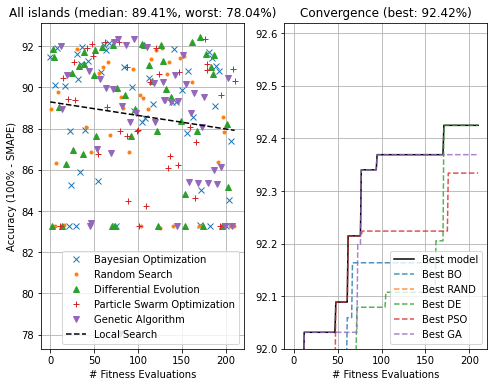

In [2]:
import numpy as np
import matplotlib.pyplot as plt

variables = [
#     "cvSmapeMeanAccuracy",
#     "holdoutMse",
    "holdoutSmapeAccuracy",
#     "holdoutIoa"
]
figure_size = [8, 6]
remove_outliers = False
outlier_std = 3
minimizing = False

def getMinimizingMaximizingArray(k, minimizing=True):
    minsArray = []
    minValue = k[0]
    for value in np.array(k):
        if minimizing:
            if value < minValue:
                minValue = value
        else:
            if value > minValue:
                minValue = value
        minsArray.append(minValue)
    return np.array(minsArray)

def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

for current_experiment in experiment_directories:

    legends = []
    for variable in variables:

        df2 = df.loc[df["experiment"] == current_experiment]
#         df2 = df2.loc[df2["optimizer"] != "ls"]

        df2 = df2.drop_duplicates()
        df2.sort_index(inplace=True)

        if remove_outliers:
            df2 = df2[~(np.abs(df2[variable] - df2[variable].mean()) > (outlier_std * df2[variable].std()))]

        dict_points = {}
        for optimizer in df2["optimizer"].unique():
            dict_points[optimizer + "_y"] = []
            dict_points[optimizer + "_x"] = []
        i = 0
        for index, row in df2.iterrows():
            optimizer = row["optimizer"]
            dict_points[optimizer + "_y"].append(row[variable])
            dict_points[optimizer + "_x"].append(i)
            i += 1

        x = np.array(range(0, len(df2[variable])))
        y = df2[variable].values


        figure_size = (8,6)
        fig, ax = plt.subplots(1, 2, figsize=figure_size)
        # fig, ax = plt.subplots(1, 1, figsize=figure_size)
        plot_id = 0
        ax[plot_id].set_ylabel("Accuracy (100% - SMAPE)")
        ax[plot_id].set_xlabel('# Fitness Evaluations')

        dict_lines = {}
        for optimizer in df2["optimizer"].unique():
            dict_lines[optimizer + "_y"] = []
            dict_lines[optimizer + "_x"] = []
        j = 0
        for index, row in df2.iterrows():
            for optimizer in df2["optimizer"].unique():
                dict_lines[optimizer + "_x"].append(j)

                if optimizer != row["optimizer"]:
                    dict_lines[optimizer + "_y"].append(0)
                else:
                    dict_lines[row["optimizer"] + "_y"].append(row[variable])
            #print(j, row["optimizer"])
            j += 1

#         z2 = np.polyfit(x, y, 2)
#         trendpoly2d = np.poly1d(z2)
#         ax.plot(x, trendpoly2d(x) , 'r--')
#         legends.append("trend 2 degree polynomial")

#         z12 = np.polyfit(x, y, 12)
#         trendpoly12d = np.poly1d(z12)
#         ax.plot(x, trendpoly12d(x) , 'c--')
#         legends.append("trend 12 degree polynomial")

        # Scatter plot all data points based on method
        i = 0
        styles = ["x", ".", "^", "+", "v", "1", "*"]
        for optimizer in df2["optimizer"].unique():
            ax[plot_id].plot(dict_points[optimizer + "_x"], dict_points[optimizer + "_y"], styles[i]);
#             legends.append(optimizer)
            i += 1
        # legends = legends + ["Bayesian Optimization (BO)", "Random (uniform) search (Rand)", "Differential Evolution (DE)", "Particle Swarm Optimization (PSO)", "Genetic Algorithm (GA)", "Local Search (LS)"]
        legends = legends + ["Bayesian Optimization", "Random Search", "Differential Evolution", "Particle Swarm Optimization", "Genetic Algorithm", "Local Search"]

        # Linear regression trend
        z = np.polyfit(x, y, 1)
        trendpoly1d = np.poly1d(z)
#         print("trendpoly1d: ", trendpoly1d)
        ax[plot_id].plot(x, trendpoly1d(x) , 'k--')
        legends.append("trend: {:.3f}*x + {:.3f}".format(z[0], z[1]))

        best_method = df2["optimizer"].loc[df2[variable].idxmin()].upper()
#         ax.set_title('Island Transpeciation - PM10 test accuracy (median: {:.2f}% +/- {:.2f}%, worst: {:.2f}%, best: {:.2f}%)'
#                      .format(df2[variable].median(), df2[variable].mad(), df2[variable].min(), df2[variable].max()))
#         ax[plot_id].set_title('Island Transpeciation - $O_3$ test (median: {:.2f}%, worst: {:.2f}%, best: {:.2f}%)'
#              .format(df2[variable].median(), df2[variable].min(), df2[variable].max()))

        ax[plot_id].set_title('All islands (median: {:.2f}%, worst: {:.2f}%)'
             .format(df2[variable].median(), df2[variable].min(), df2[variable].max()))

#         ax.plot(x, getMinimizingMaximizingArray(df2[variable].values, minimizing), "b-");
# #         legends.append("minimizing " + variable)
#         legends.append("Best model")
        ax[plot_id].legend(legends, loc="lower right")
        ax[plot_id].grid(True)

        plot_id = 1
        # fig, ax = plt.subplots(1, 1, figsize=figure_size)
        # ax[plot_id].set_title('Island Transpeciation - $O_3$ test (median: {:.2f}%, worst: {:.2f}%, best: {:.2f}%)'
        #      .format(df2[variable].median(), df2[variable].min(), df2[variable].max()))
        ax[plot_id].set_title('Convergence (best: {:.2f}%)'
             .format(df2[variable].max()))
        # ax[plot_id].set_ylabel("Accuracy (100% - SMAPE)")
        ax[plot_id].set_xlabel('# Fitness Evaluations')

        legends = []
        ax[plot_id].plot(x, getMinimizingMaximizingArray(df2[variable].values, minimizing), "k", alpha=1.0);
        legends.append("Best model")

        k = 0
        for optimizer in df2["optimizer"].unique():
            if optimizer not in [""]: # ["ls", "rand", "pso"]:
                ax[plot_id].plot(x, getMinimizingMaximizingArray(dict_lines[optimizer + "_y"], minimizing), "--", alpha=0.8);
                legends.append("Best " + optimizer.upper())
            k += 1

        ax[plot_id].legend(legends, loc="lower right")
        # ax[plot_id].set_ylim([df2[variable].min(), df2[variable].max()])
        ax[plot_id].set_ylim([92, 92.62])
        # ax.set_yscale("log")
        # ax.set_ylim([df2[variable].min(), df2[variable].max()])
        ax[plot_id].grid(True)

        fig.savefig("{}_dual.svg".format(current_experiment))
        fig.savefig("{}_dual.pdf".format(current_experiment))
#         break
#     break

Backup

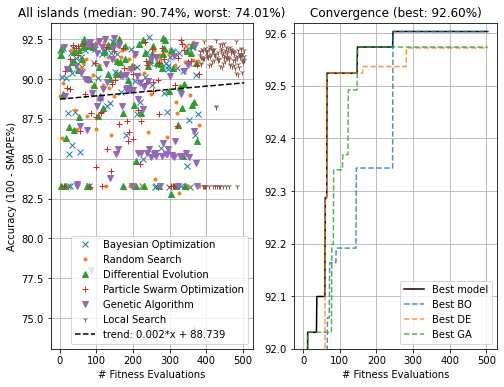

In [14]:
import numpy as np
import matplotlib.pyplot as plt

variables = [
#     "cvSmapeMeanAccuracy",
#     "holdoutMse",
    "holdoutSmapeAccuracy",
#     "holdoutIoa"
]
figure_size = [8, 6]
remove_outliers = False
outlier_std = 3
minimizing = False

def getMinimizingMaximizingArray(k, minimizing=True):
    minsArray = []
    minValue = k[0]
    for value in np.array(k):
        if minimizing:
            if value < minValue:
                minValue = value
        else:
            if value > minValue:
                minValue = value
        minsArray.append(minValue)
    return np.array(minsArray)

def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

for current_experiment in experiment_directories:

    legends = []
    for variable in variables:

        df2 = df.loc[df["experiment"] == current_experiment]
#         df2 = df2.loc[df2["optimizer"] != "ls"]

        df2 = df2.drop_duplicates()
        df2.sort_index(inplace=True)

        if remove_outliers:
            df2 = df2[~(np.abs(df2[variable] - df2[variable].mean()) > (outlier_std * df2[variable].std()))]

        dict_points = {}
        for optimizer in df2["optimizer"].unique():
            dict_points[optimizer + "_y"] = []
            dict_points[optimizer + "_x"] = []
        i = 0
        for index, row in df2.iterrows():
            optimizer = row["optimizer"]
            dict_points[optimizer + "_y"].append(row[variable])
            dict_points[optimizer + "_x"].append(i)
            i += 1

        x = np.array(range(0, len(df2[variable])))
        y = df2[variable].values


        figure_size = (8,6)
        fig, ax = plt.subplots(1, 2, figsize=figure_size)
        # fig, ax = plt.subplots(1, 1, figsize=figure_size)
        plot_id = 0
        ax[plot_id].set_ylabel("Accuracy (100% - SMAPE)")
        ax[plot_id].set_xlabel('# Fitness Evaluations')

        dict_lines = {}
        for optimizer in df2["optimizer"].unique():
            dict_lines[optimizer + "_y"] = []
            dict_lines[optimizer + "_x"] = []
        j = 0
        for index, row in df2.iterrows():
            for optimizer in df2["optimizer"].unique():
                dict_lines[optimizer + "_x"].append(j)

                if optimizer != row["optimizer"]:
                    dict_lines[optimizer + "_y"].append(0)
                else:
                    dict_lines[row["optimizer"] + "_y"].append(row[variable])
            j += 1

#         z2 = np.polyfit(x, y, 2)
#         trendpoly2d = np.poly1d(z2)
#         ax.plot(x, trendpoly2d(x) , 'r--')
#         legends.append("trend 2 degree polynomial")

#         z12 = np.polyfit(x, y, 12)
#         trendpoly12d = np.poly1d(z12)
#         ax.plot(x, trendpoly12d(x) , 'c--')
#         legends.append("trend 12 degree polynomial")

        # Scatter plot all data points based on method
        i = 0
        styles = ["x", ".", "^", "+", "v", "1", "*"]
        for optimizer in df2["optimizer"].unique():
            ax[plot_id].plot(dict_points[optimizer + "_x"], dict_points[optimizer + "_y"], styles[i]);
#             legends.append(optimizer)
            i += 1
        # legends = legends + ["Bayesian Optimization (BO)", "Random (uniform) search (Rand)", "Differential Evolution (DE)", "Particle Swarm Optimization (PSO)", "Genetic Algorithm (GA)", "Local Search (LS)"]
        legends = legends + ["Bayesian Optimization", "Random Search", "Differential Evolution", "Particle Swarm Optimization", "Genetic Algorithm", "Local Search"]

        # Linear regression trend
        z = np.polyfit(x, y, 1)
        trendpoly1d = np.poly1d(z)
#         print("trendpoly1d: ", trendpoly1d)
        ax[plot_id].plot(x, trendpoly1d(x) , 'k--')
        legends.append("trend: {:.3f}*x + {:.3f}".format(z[0], z[1]))

        best_method = df2["optimizer"].loc[df2[variable].idxmin()].upper()
#         ax.set_title('Island Transpeciation - PM10 test accuracy (median: {:.2f}% +/- {:.2f}%, worst: {:.2f}%, best: {:.2f}%)'
#                      .format(df2[variable].median(), df2[variable].mad(), df2[variable].min(), df2[variable].max()))
#         ax[plot_id].set_title('Island Transpeciation - $O_3$ test (median: {:.2f}%, worst: {:.2f}%, best: {:.2f}%)'
#              .format(df2[variable].median(), df2[variable].min(), df2[variable].max()))

        ax[plot_id].set_title('All islands (median: {:.2f}%, worst: {:.2f}%)'
             .format(df2[variable].median(), df2[variable].min(), df2[variable].max()))

#         ax.plot(x, getMinimizingMaximizingArray(df2[variable].values, minimizing), "b-");
# #         legends.append("minimizing " + variable)
#         legends.append("Best model")
        ax[plot_id].legend(legends, loc="lower right")
        ax[plot_id].grid(True)

        plot_id = 1
        # fig, ax = plt.subplots(1, 1, figsize=figure_size)
        # ax[plot_id].set_title('Island Transpeciation - $O_3$ test (median: {:.2f}%, worst: {:.2f}%, best: {:.2f}%)'
        #      .format(df2[variable].median(), df2[variable].min(), df2[variable].max()))
        ax[plot_id].set_title('Convergence (best: {:.2f}%)'
             .format(df2[variable].max()))
        # ax[plot_id].set_ylabel("Accuracy (100% - SMAPE)")
        ax[plot_id].set_xlabel('# Fitness Evaluations')

        legends = []
        ax[plot_id].plot(x, getMinimizingMaximizingArray(df2[variable].values, minimizing), "k", alpha=1.0);
        legends.append("Best model")

        k = 0
        for optimizer in df2["optimizer"].unique():
            if optimizer not in ["ls", "rand", "pso"]:
                ax[plot_id].plot(x, getMinimizingMaximizingArray(dict_lines[optimizer + "_y"], minimizing), "--", alpha=0.8);
                legends.append("Best " + optimizer.upper())
            k += 1

        ax[plot_id].legend(legends, loc="lower right")
        # ax[plot_id].set_ylim([df2[variable].min(), df2[variable].max()])
        ax[plot_id].set_ylim([92, 92.62])
        # ax.set_yscale("log")
        # ax.set_ylim([df2[variable].min(), df2[variable].max()])
        ax[plot_id].grid(True)

        fig.savefig("{}_dual.svg".format(current_experiment))
        fig.savefig("{}_dual.pdf".format(current_experiment))
#         break
#     break

In [148]:
df2["optimizer"].unique()

array(['bo', 'rand', 'de', 'pso', 'ga', 'ls'], dtype=object)

In [265]:
dict_points[optimizer + "_y"].index(max(dict_points[optimizer + "_y"]))

46

In [271]:
k = getMinimizingMaximizingArray(df2[variable].values, minimizing)
print(k.max(), k.argmax())

92.603120189299 245


In [280]:
optimizer="bo"
l = getMinimizingMaximizingArray(dict_lines[optimizer + "_y"], minimizing)
print(l.max(), l.argmax())
for i in range(l.shape[0]):
    print(i, l[i])

92.603120189299 245
0 91.49489344623072
1 91.49489344623072
2 91.49489344623072
3 91.49489344623072
4 91.49489344623072
5 91.49489344623072
6 91.49489344623072
7 91.49489344623072
8 91.9133278971684
9 91.9133278971684
10 91.9133278971684
11 91.9133278971684
12 91.9133278971684
13 91.9133278971684
14 91.9133278971684
15 91.9133278971684
16 91.9133278971684
17 91.9133278971684
18 91.9133278971684
19 91.9133278971684
20 91.9133278971684
21 91.9133278971684
22 91.9133278971684
23 91.9133278971684
24 91.9133278971684
25 91.9133278971684
26 91.9133278971684
27 91.9133278971684
28 91.9133278971684
29 91.9133278971684
30 91.9133278971684
31 91.9133278971684
32 91.9133278971684
33 91.9133278971684
34 91.9133278971684
35 91.9133278971684
36 91.95184986397038
37 91.95184986397038
38 91.95184986397038
39 91.95184986397038
40 91.95184986397038
41 91.95184986397038
42 91.95184986397038
43 91.95184986397038
44 91.95184986397038
45 91.95184986397038
46 91.95184986397038
47 91.95184986397038
48 91.9518

Backup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

variables = [
#     "cvSmapeMeanAccuracy",
#     "holdoutMse",
    "holdoutSmapeAccuracy",
#     "holdoutIoa"
]
figure_size = [8, 6]
remove_outliers = False
outlier_std = 3
minimizing = False

def getMinimizingMaximizingArray(k, minimizing=True):
    minsArray = []
    minValue = k[0]
    for value in np.array(k):
        if minimizing:
            if value < minValue:
                minValue = value
        else:
            if value > minValue:
                minValue = value
        minsArray.append(minValue)
    return np.array(minsArray)

def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

for current_experiment in experiment_directories:

    legends = []
    for variable in variables:

        df2 = df.loc[df["experiment"] == current_experiment]
#         df2 = df2.loc[df2["optimizer"] != "ls"]

        df2 = df2.drop_duplicates()
        df2.sort_index(inplace=True)

        if remove_outliers:
            df2 = df2[~(np.abs(df2[variable] - df2[variable].mean()) > (outlier_std * df2[variable].std()))]

        dict_points = {}
        for optimizer in df2["optimizer"].unique():
            dict_points[optimizer + "_y"] = []
            dict_points[optimizer + "_x"] = []
        i = 0
        for index, row in df2.iterrows():
            optimizer = row["optimizer"]
            dict_points[optimizer + "_y"].append(row[variable])
            dict_points[optimizer + "_x"].append(i)
            i += 1

        x = np.array(range(0, len(df2[variable])))
        y = df2[variable].values

        fig, ax = plt.subplots(1, 1, figsize=figure_size)
        ax.set_ylabel("Accuracy (100% - SMAPE)")
        ax.set_xlabel('# Fitness Evaluations')

#         z2 = np.polyfit(x, y, 2)
#         trendpoly2d = np.poly1d(z2)
#         ax.plot(x, trendpoly2d(x) , 'r--')
#         legends.append("trend 2 degree polynomial")

#         z12 = np.polyfit(x, y, 12)
#         trendpoly12d = np.poly1d(z12)
#         ax.plot(x, trendpoly12d(x) , 'c--')
#         legends.append("trend 12 degree polynomial")

        # Scatter plot all data points based on method
        i = 0
        styles = ["x", ".", "^", "+", "v", "1", "*"]
        for optimizer in df2["optimizer"].unique():
            ax.plot(dict_points[optimizer + "_x"], dict_points[optimizer + "_y"], styles[i]);
#             legends.append(optimizer)
            i += 1
        legends = legends + ["Bayesian Optimization (BO)", "Random (uniform) search (Rand)", "Differential Evolution (DE)", "Particle Swarm Optimization (PSO)", "Genetic Algorithm (GA)", "Local Search (LS)"]

        # Linear regression trend
        z = np.polyfit(x, y, 1)
        trendpoly1d = np.poly1d(z)
#         print("trendpoly1d: ", trendpoly1d)
        ax.plot(x, trendpoly1d(x) , 'k--')
        legends.append("trend: {:.3f}*x + {:.3f}".format(z[0], z[1]))

        best_method = df2["optimizer"].loc[df2[variable].idxmin()].upper()
#         ax.set_title('Island Transpeciation - PM10 test accuracy (median: {:.2f}% +/- {:.2f}%, worst: {:.2f}%, best: {:.2f}%)'
#                      .format(df2[variable].median(), df2[variable].mad(), df2[variable].min(), df2[variable].max()))
        ax.set_title('Island Transpeciation - $O_3$ test (median: {:.2f}%, worst: {:.2f}%, best: {:.2f}%)'
             .format(df2[variable].median(), df2[variable].min(), df2[variable].max()))

        ax.plot(x, getMinimizingMaximizingArray(df2[variable].values, minimizing), "b-");
#         legends.append("minimizing " + variable)
        legends.append("Best model")

        ax.legend(legends)

        ax.grid(True)
        fig.savefig("{}.svg".format(current_experiment))
        fig.savefig("{}.pdf".format(current_experiment))
#         break
#     break

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

variables = [
#     "cvSmapeMeanAccuracy",
#     "holdoutMse",
    "holdoutSmapeAccuracy",
#     "holdoutIoa"
]
figure_size = [10, 8]
remove_outliers = False
outlier_std = 2
minimizing = False

def getMinimizingMaximizingArray(k, minimizing=True):
    minsArray = []
    minValue = k[0]
    for value in np.array(k):
        if minimizing:
            if value < minValue:
                minValue = value
        else:
            if value > minValue:
                minValue = value
        minsArray.append(minValue)
    return np.array(minsArray)

def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

for current_experiment in experiment_directories:

    legends = []
    for variable in variables:

        df2 = df.loc[df["experiment"] == current_experiment]

#         df2 = df2.loc[df2["optimizer"] != "ls"]

        df2 = df2.drop_duplicates()
        df2.sort_index(inplace=True)

        if remove_outliers:
            df2 = df2[~(np.abs(df2[variable] - df2[variable].mean()) > (outlier_std * df2[variable].std()))]

        dict_points = {}
        for optimizer in df2["optimizer"].unique():
            dict_points[optimizer + "_y"] = []
            dict_points[optimizer + "_x"] = []
        i = 0
        for index, row in df2.iterrows():
            optimizer = row["optimizer"]
            dict_points[optimizer + "_y"].append(row[variable])
            dict_points[optimizer + "_x"].append(i)
            i += 1

        x = np.array(range(0, len(df2[variable])))
        y = df2[variable].values

        fig, ax = plt.subplots(1, 1, figsize=figure_size)
        ax.set_ylabel(variable)
        ax.set_xlabel('# Fitness Evaluations')

        # Linear regression trend
        z = np.polyfit(x, y, 1)
        trendpoly1d = np.poly1d(z)
#         print("trendpoly1d: ", trendpoly1d)
        ax.plot(x, trendpoly1d(x) , 'k--')
        legends.append("trend " + variable + ": {:.3f}*x + {:.3f}".format(z[0], z[1]))

        z2 = np.polyfit(x, y, 2)
        trendpoly2d = np.poly1d(z2)
        ax.plot(x, trendpoly2d(x) , 'r--')
        legends.append("trend 2 degree polynomial")

        z12 = np.polyfit(x, y, 12)
        trendpoly12d = np.poly1d(z12)
        ax.plot(x, trendpoly12d(x) , 'c--')
        legends.append("trend 12 degree polynomial")

        # Scatter plot all data points based on method
        i = 0
        styles = ["x", ".", "^", "+", "v", "1", "*"]
        for optimizer in df2["optimizer"].unique():
            ax.plot(dict_points[optimizer + "_x"], dict_points[optimizer + "_y"], styles[i]);
            legends.append(optimizer)
            i += 1

        ax.plot(x, getMinimizingMaximizingArray(df2[variable].values, minimizing), "b-");
        legends.append("minimizing " + variable)

        ax.legend(legends)
        best_method = df2["optimizer"].loc[df2[variable].idxmin()]
        ax.set_title('{} (evals: {}, min: {:.2f}, max: {:.2f}, median: {:.2f} +/- {:.2f}, mean: {:.2f} +/- {:.2f}, best: {}) - Experiment: {}'
                     .format(variable, len(df2[variable]), df2[variable].min(), df2[variable].max(), df2[variable].median(), df2[variable].mad(),
                             df2[variable].mean(), df2[variable].std(), best_method, current_experiment))
        ax.grid(True)

#         break
#     break

## Worker execution times: Bar chart with error bars

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np

def flatten(seq, container=None):
    if container is None:
        container = []
    for s in seq:
        try:
            iter(s)  # check if it's iterable
        except TypeError:
            container.append(s)
        else:
            flatten(s, container)
    return container

workers = df["worker"].unique()

means = []
samples = 0
outlier_std = 3
for current_worker in workers:
    experiment_means = []
    for current_experiment in experiment_directories:
        df_worker = df.loc[df["experiment"] == current_experiment]
        df_worker = df_worker.loc[df_worker["worker"] == current_worker]
        df_worker = df_worker.drop_duplicates()
        df_worker = df_worker.dropna()
        df_worker.sort_index(inplace=True)
        df_worker['datetimestamp'] = df_worker.index
        df_worker = df_worker[~(np.abs(df_worker["datetimestamp"] - df_worker["datetimestamp"].mean()) > (outlier_std * df_worker["datetimestamp"].std()))]
        diff = df_worker["datetimestamp"].diff().dropna()
        mean = diff.mean(skipna=True)
        if "P100" in current_worker or "4xV100" in current_worker:
            mean *= 4
        if mean is not None and not math.isnan(mean):
            samples += diff.size
            experiment_means.append(mean / 60.0)
    means.append(experiment_means)

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 14))
workers = list(workers)
fourV100 = workers.index('EC2/4xV100a')
oneV100 = workers.index('EC2/1xV100')
means[fourV100].append(means[oneV100][0])
del means[oneV100]

all_data = means
labels = []
for x, y in zip(['Tesla P100', 'GTX 970 & 1070Ti', 'Tesla V100', 'Jetson TX2'], [np.mean(x) for x in all_data]):
    labels.append("{}\n({:.2f} mins/model)".format(x, y))

axes[0].violinplot(all_data, showmeans=False, showmedians=True)
axes[0].set_title('Violin plot - RNN (4 layers) training times vs GPU ({} samples, 99.73% CI)'.format(samples))
axes[1].boxplot(all_data)
axes[1].set_title('Box plot - RNN (4 layers) training times vs GPU ({} samples, 99.73% CI)'.format(samples))
for ax in axes:
    ax.yaxis.grid(True)
    ax.set_xticks([y+1 for y in range(len(all_data))])
    ax.set_xlabel('GPU Workers')
    ax.set_ylabel('Time (minutes)')
plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
         xticklabels=labels)
plt.savefig("rnnTrainingTimes.svg")
plt.savefig("rnnTrainingTimes.png")
plt.show()

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np

def flatten(seq, container=None):
    if container is None:
        container = []
    for s in seq:
        try:
            iter(s)  # check if it's iterable
        except TypeError:
            container.append(s)
        else:
            flatten(s, container)
    return container

workers = df["worker"].unique()

means = []
samples = 0
outlier_std = 3

for current_worker in workers:
    experiment_means = []
    for current_experiment in experiment_directories:
        df_worker = df.loc[df["experiment"] == current_experiment]
        df_worker = df_worker.loc[df_worker["worker"] == current_worker]
        df_worker = df_worker.drop_duplicates()
        df_worker = df_worker.dropna()
        df_worker.sort_index(inplace=True)
        df_worker['datetimestamp'] = df_worker.index
        df_worker = df_worker[~(np.abs(df_worker["datetimestamp"] - df_worker["datetimestamp"].mean()) > (outlier_std * df_worker["datetimestamp"].std()))]
        diff = df_worker["datetimestamp"].diff().dropna()
        mean = diff.mean(skipna=True)
        if "P100" in current_worker or "4xV100" in current_worker:
            mean *= 4
        if mean is not None and not math.isnan(mean):
            samples += diff.size
            experiment_means.append(mean / 60.0)
    means.append(experiment_means)

# Plot


figure_size = (6, 4)  # (16, 14)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figure_size)
workers = list(workers)
fourV100 = workers.index('EC2/4xV100a')
oneV100 = workers.index('EC2/1xV100')
means[fourV100].append(means[oneV100][0])
del means[oneV100]

all_data = means
labels = []
for x, y in zip(['Tesla P100', 'GTX 970 & 1070Ti', 'Tesla V100', 'Jetson TX2'], [np.mean(x) for x in all_data]):
    labels.append("{}\n≈{:.2f}\nmins/model".format(x, y))

axes.violinplot(all_data, showmeans=False, showmedians=True)
axes.set_title('Island DNN training times vs GPU ({} samples, 99.73% CI)'.format(samples))
axes.set_title('Training times vs GPU ({} samples, 99.73% CI)'.format(samples))
# axes[1].boxplot(all_data)
# axes[1].set_title('Box plot - RNN (4 layers) training times vs GPU ({} samples, 99.73% CI)'.format(samples))

axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_xlabel('GPU Workers')
axes.set_ylabel('Time (minutes)')
plt.setp(axes, xticks=[y+1 for y in range(len(all_data))], xticklabels=labels)
plt.savefig("rnnTrainingTimes.svg")
plt.savefig("rnnTrainingTimes.png")
plt.show()

In [ ]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np


models_per_hour = []
models_per_hour_std = []
for gpu_worker in all_data:
    models_per_hour.append(np.mean(60.0 / np.array(gpu_worker)))
    models_per_hour_std.append(np.std(60.0 / np.array(gpu_worker)))
prices = [5281, (136 + 369) / 2.0, 6865, 352]
price_per_model_hour = np.array(prices) / np.array(models_per_hour)

price_per_model_hour_std = price_per_model_hour * (np.array(models_per_hour_std) / np.array(models_per_hour))
print("price_per_model_hour_std", price_per_model_hour_std)

gpu_workers = ['Tesla P100', 'GTX 970 & 1070Ti', 'Tesla V100', 'Jetson TX2']
price_per_model_hour = [x for y,x in sorted(zip(gpu_workers, price_per_model_hour))]
gpu_workers = [y for y,x in sorted(zip(gpu_workers, price_per_model_hour))]

price_per_model_hour_std = [26.98099847, 64.96931466, 495.39481663,  110.15980803]  # TODO: hardcoded

x = np.arange(4)
def millions(x, pos):
    return '{:.0f} €'.format(x)

formatter = FuncFormatter(millions)

fig, ax = plt.subplots(figsize=(12, 4))
ax.xaxis.set_major_formatter(formatter)
plt.barh(x, price_per_model_hour, xerr=price_per_model_hour_std)
# plt.barh(x, price_per_model_hour)
ax.set_title('Cost per model-hour - RNN (4 layers) vs GPU ({} samples 99.73% CI)'.format(samples))
ax.set_ylabel('GPU Workers')
ax.set_xlabel('Price (€)')
plt.yticks(x, gpu_workers)
for i, v in enumerate(price_per_model_hour):
    ax.text(v + 4, i + 0.1, str(round(v, 1)) + "€ +/- {:.1f}€ per model-hour".format(price_per_model_hour_std[i]) , color='blue', fontweight='bold')
plt.show()

## All models structure

In [ ]:
import os
import pandas as pd
import glob
import re
import numpy as np
import matplotlib.pyplot as plt

run_directory_prefix = "../models/NarxModelSearch/runs/"
file_name_pattern = "*Runs.csv"
columns = ["datetime", "iteration", "island", "cvMseMean", "cvMseStd", "cvSmapeMean", "cvSmapeStd", "holdoutRmse", "holdoutSmape", "holdoutMape", "holdoutMse", "holdoutIoa", "full_parameters"]

experiment_directories = ["18CellularAutomata3DGrid3x3x3_5AgentsO3_1994-2018_16_stations_calendar",
                          "18CellularAutomata3DGrid3x3x3_20AgentsO3_1994-2018_16_stations_calendar",
                          "18Islands20AgentsO3_1994-2018_16_stations_calendar",
                          "18Islands5AgentsO3_1994-2018_16_stations_calendar",
                          "18CellularAutomata3DGrid3x3x3_5AgentsPM10_1994-2018_16_stations_calendar",
                          "18Islands20AgentsPM10_1994-2018_16_stations_calendar",
                          "18Islands5AgentsPM10_1994-2018_16_stations_calendar"
                         ]

run_directories = []
for experiment_directory in experiment_directories:
    new_run_directory = run_directory_prefix + experiment_directory + "/"
#     print("new_run_directory:", new_run_directory)
    run_directories.append(new_run_directory)

worker_directories = ["local", "TX2"]

# print(run_directories)

dirs_list = []
for run_directory in run_directories:
    dirs_list.append(os.listdir(run_directory))
#     print("dirs:", os.listdir(run_directory))

for dirs in dirs_list:
    for item in dirs:
        if item not in worker_directories:
            sub_items = os.listdir(run_directories[0] + item)
            for sub_item in sub_items:
                sub_path = item +"/" + sub_item
#                 print("sub_path:", item +"/" + sub_item)
                worker_directories.append(sub_path)

#
# "worker_directories:", worker_directories)

paths = []
for run_directory in run_directories:
    for worker_directory in worker_directories:
        experiment = ""
        if run_directory.startswith(run_directory_prefix):
            experiment = run_directory[len(run_directory_prefix):-1]
#         print("experiment:", experiment)
        paths.append((run_directory + worker_directory + "/logs/", worker_directory, experiment))

# print(len(paths))

frames = []
for path in paths:
    for csv_file_path in glob.glob(path[0] + file_name_pattern):
#         print("csv_file_path:", csv_file_path)
#         print("csv_file     :", csv_file)
        df = pd.read_csv(csv_file_path, names=columns, engine="python", index_col="datetime", parse_dates=True)

        if "EC2" in path[1]:  # EC2 -> + 1 hour (Ireland)
            df.index = df.index + 3600
        if "TX2" in path[1]:  # TX2 -> + 2 hours (UTC)
            df.index = df.index + 3600 * 2

        df.sort_index(inplace=True)
        df["optimizer"] = str(re.search('(.{1,6})Runs.csv', os.path.basename(csv_file_path)).group(1))
        df["worker"] = path[1]
        df["experiment"] = path[2]
        df["cvSmapeMeanAccuracy"] = 100 - df["cvSmapeMean"]
        df["holdoutSmapeAccuracy"] = 100 - df["holdoutSmape"]

        full_parameters = []
        for params in df["full_parameters"].tolist():
#             print(params)
            full_parameters.append([float(z) for z in params.replace('[', '').replace(']', '').split(", ")])

        df["full_parameters"] = full_parameters
        a = ["batch_size",
            "epoch_size",
            "optimizer",
            "units1",
            "units2",
            "units3",
            "dropout1",
            "dropout2",
            "dropout3",
            "recurrent_dropout1",
            "recurrent_dropout2",
            "recurrent_dropout3",
            "gaussian_noise_std1",
            "gaussian_noise_std2",
            "gaussian_noise_std3",
            "batch_normalization1",
            "batch_normalization2",
            "batch_normalization3",
            "gaussian_noise1",
            "gaussian_noise2",
            "gaussian_noise3",
            "layer_type1",
            "layer_type2",
            "layer_type3",
            "layer_initializer1",
            "layer_initializer2",
            "layer_initializer3"]

        c = 0
        for asdf in zip(*full_parameters):
            df[a[c]] = asdf
            c +=1

        frames.append(df)
#         break

df = pd.concat(frames)
df.sort_index(inplace=True)

print("df.shape:", df.shape)
df.tail()

In [ ]:
import os
import pandas as pd
import glob
import re
import numpy as np
import matplotlib.pyplot as plt

run_directory_prefix = "../models/NarxModelSearch/runs/"
file_name_pattern = "*Runs.csv"
columns = ["datetime", "iteration", "island", "cvMseMean", "cvMseStd", "cvSmapeMean", "cvSmapeStd", "holdoutRmse", "holdoutSmape", "holdoutMape", "holdoutMse", "holdoutIoa", "full_parameters"]

experiment_directories = ["18CellularAutomata3DGrid3x3x3_5AgentsO3_1994-2018_16_stations_calendar",
                          "18CellularAutomata3DGrid3x3x3_20AgentsO3_1994-2018_16_stations_calendar",
                          "18Islands20AgentsO3_1994-2018_16_stations_calendar",
                          "18Islands5AgentsO3_1994-2018_16_stations_calendar",
                          "18CellularAutomata3DGrid3x3x3_5AgentsPM10_1994-2018_16_stations_calendar",
                          "18Islands20AgentsPM10_1994-2018_16_stations_calendar",
                          "18Islands5AgentsPM10_1994-2018_16_stations_calendar"
                         ]

run_directories = []
for experiment_directory in experiment_directories:
    new_run_directory = run_directory_prefix + experiment_directory + "/"
#     print("new_run_directory:", new_run_directory)
    run_directories.append(new_run_directory)

worker_directories = ["local", "TX2"]

# print(run_directories)

dirs_list = []
for run_directory in run_directories:
    dirs_list.append(os.listdir(run_directory))
#     print("dirs:", os.listdir(run_directory))

for dirs in dirs_list:
    for item in dirs:
        if item not in worker_directories:
            sub_items = os.listdir(run_directories[0] + item)
            for sub_item in sub_items:
                sub_path = item +"/" + sub_item
#                 print("sub_path:", item +"/" + sub_item)
                worker_directories.append(sub_path)

# print("worker_directories:", worker_directories)

paths = []
for run_directory in run_directories:
    for worker_directory in worker_directories:
        experiment = ""
        if run_directory.startswith(run_directory_prefix):
            experiment = run_directory[len(run_directory_prefix):-1]
#         print("experiment:", experiment)
        paths.append((run_directory + worker_directory + "/logs/", worker_directory, experiment))

# print(len(paths))

frames = []
for path in paths:
    for csv_file_path in glob.glob(path[0] + file_name_pattern):
#         print("csv_file_path:", csv_file_path)
#         print("csv_file     :", csv_file)
        df = pd.read_csv(csv_file_path, names=columns, engine="python", index_col="datetime", parse_dates=True)

        if "EC2" in path[1]:  # EC2 -> + 1 hour (Ireland)
            df.index = df.index + 3600
        if "TX2" in path[1]:  # TX2 -> + 2 hours (UTC)
            df.index = df.index + 3600 * 2

        df.sort_index(inplace=True)
        df["optimizer"] = str(re.search('(.{1,6})Runs.csv', os.path.basename(csv_file_path)).group(1))
        df["worker"] = path[1]
        df["experiment"] = path[2]
        df["cvSmapeMeanAccuracy"] = 100 - df["cvSmapeMean"]
        df["holdoutSmapeAccuracy"] = 100 - df["holdoutSmape"]


        full_parameters = []
        for params in df["full_parameters"].tolist():
#             print(params)
            full_parameters.append([float(z) for z in params.replace('[', '').replace(']', '').split(", ")])

        df["full_parameters"] = full_parameters
        a = ["batch_size",
            "epoch_size",
            "optimizer",
            "units1",
            "units2",
            "units3",
            "dropout1",
            "dropout2",
            "dropout3",
            "recurrent_dropout1",
            "recurrent_dropout2",
            "recurrent_dropout3",
            "gaussian_noise_std1",
            "gaussian_noise_std2",
            "gaussian_noise_std3",
            "batch_normalization1",
            "batch_normalization2",
            "batch_normalization3",
            "gaussian_noise1",
            "gaussian_noise2",
            "gaussian_noise3",
            "layer_type1",
            "layer_type2",
            "layer_type3",
            "layer_initializer1",
            "layer_initializer2",
            "layer_initializer3"]

        c = 0
        for asdf in zip(*full_parameters):
            df[a[c]] = asdf
            c +=1

        df = df.nlargest(1, 'holdoutSmapeAccuracy') # TODO: top 1 champion models

        frames.append(df)
#         break

df = pd.concat(frames)
df.sort_index(inplace=True)

# df = df.nlargest(20, 'holdoutSmapeAccuracy') # TODO: get top 10 champion models
print("df.shape:", df.shape)
df.tail()

In [ ]:
units1 = []
units2 = []
units3 = []
layer_type1 = []
layer_type2 = []
layer_type3 = []

experiment_directories = ["18CellularAutomata3DGrid3x3x3_5AgentsO3_1994-2018_16_stations_calendar",
                          "18CellularAutomata3DGrid3x3x3_20AgentsO3_1994-2018_16_stations_calendar",  # BEST O3
                          "18Islands20AgentsO3_1994-2018_16_stations_calendar",
                          "18Islands5AgentsO3_1994-2018_16_stations_calendar",
                          "18CellularAutomata3DGrid3x3x3_5AgentsPM10_1994-2018_16_stations_calendar",
                          "18Islands20AgentsPM10_1994-2018_16_stations_calendar",  # BEST PM10
                          "18Islands5AgentsPM10_1994-2018_16_stations_calendar"
                         ]

# selected_experiments = [experiment_directories[0, 1, 2, 3, 4]]

# df_models = df.loc[df["experiment"] == experiment_directories[0]]  # For 1 experiment
df_models = df[df['experiment'].isin(experiment_directories[0:1])]
# df_models = df[df['experiment'].isin(experiment_directories[4:7])]  # For many experiments
df_models = df[df['experiment'].isin(experiment_directories)]  # all experiments
first_iterations = 400
for element in df_models["full_parameters"].head(first_iterations):  # For the first EA iterations
# for element in df_models["full_parameters"]:
    units1.append(element[3])
    units2.append(element[4])
    units3.append(element[5])
    layer_type1.append(np.around(element[21], decimals=0).astype(int))
    layer_type2.append(np.around(element[22], decimals=0).astype(int))
    layer_type3.append(np.around(element[23], decimals=0).astype(int))
#     layer_type1.append(element[15])
#     layer_type2.append(element[16])
#     layer_type3.append(element[17])
units = [units1, units2, units3]
layer_types = [layer_type1, layer_type2, layer_type3]

## Best:

In [ ]:
best_df_model = df_models.loc[df_models["holdoutSmapeAccuracy"] == df_models["holdoutSmapeAccuracy"].max()]
best_pm10_params = best_df_model["full_parameters"]
layer_types_list = ["LSTM", "BiLSTM", "GRU", "BiGRU", "RNN", "BiRNN"]
for element in best_pm10_params:
    print("\nBest model(units):")
    print(np.around(element[3], decimals=0).astype(int), end=", ")
    print(np.around(element[4], decimals=0).astype(int), end=", ")
    print(np.around(element[5], decimals=0).astype(int), end="")
    print("\nBest model(layers):")
    print(layer_types_list[np.around(element[21], decimals=0).astype(int)], end=", ")
    print(layer_types_list[np.around(element[22], decimals=0).astype(int)], end=", ")
    print(layer_types_list[np.around(element[23], decimals=0).astype(int)], end=", ")
best_df_model
list(best_pm10_params)
np.around(list(best_pm10_params), decimals=0).astype(int)
print("\nMax holdoutSmapeAccuracy: {:.2f}%".format(df_models["holdoutSmapeAccuracy"].max()))
print("\nMin holdoutMse: {:.2f}".format(df_models["holdoutMse"].min()))
print("\nMin cvMseMean: {:.2f}".format(df_models["cvMseMean"].min()))

## Worst:

In [ ]:
worst_df_model = df_models.loc[df_models["holdoutSmapeAccuracy"] == df_models["holdoutSmapeAccuracy"].min()]
worst_pm10_params = worst_df_model["full_parameters"]
layer_types_list = ["LSTM", "BiLSTM", "GRU", "BiGRU", "RNN", "BiRNN"]
for element in worst_pm10_params:
    print("\nBest model(units):")
    print(np.around(element[3], decimals=0).astype(int), end=", ")
    print(np.around(element[4], decimals=0).astype(int), end=", ")
    print(np.around(element[5], decimals=0).astype(int), end="")
    print("\nBest model(layers):")
    print(layer_types_list[np.around(element[21], decimals=0).astype(int)], end=", ")
    print(layer_types_list[np.around(element[22], decimals=0).astype(int)], end=", ")
    print(layer_types_list[np.around(element[23], decimals=0).astype(int)], end=", ")

worst_df_model
list(worst_pm10_params)
np.around(list(worst_pm10_params), decimals=0).astype(int)
print("\nMax holdoutSmapeAccuracy: {:.2f}%".format(df_models["holdoutSmapeAccuracy"].min()))
print("\nMax holdoutMse: {:.2f}".format(df_models["holdoutMse"].max()))
print("\nMax cvMseMean: {:.2f}".format(df_models["cvMseMean"].max()))

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 14))
samples = len(units[0])
labels = ["First Layer", "Second Layer", "Third Layer"]
all_data = units

axes[0].violinplot(all_data, showmeans=False, showmedians=True)
axes[0].set_title('Violin plot - RNN (4 layers) layer unit count ({} samples)'.format(samples))
axes[1].boxplot(all_data)
axes[1].set_title('Box plot - RNN (4 layers) layer unit count ({} samples)'.format(samples))
for ax in axes:
    ax.yaxis.grid(True)
    ax.set_xticks([y+1 for y in range(len(all_data))])
    ax.set_xlabel('Layers')
    ax.set_ylabel('Unit count')
plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
         xticklabels=labels)
plt.show()

In [ ]:
# Plot
import math
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 14))
samples = len(layer_types[0])
labels = ["First Layer", "Second Layer", "Third Layer"]
all_data = layer_types
layer_type_labels = ['LSTM', 'LSTM', 'BiLSTM', 'GRU', 'BiGRU', 'SimpleRNN', 'BiSimpleRNN']

axes[0].violinplot(all_data, showmeans=False, showmedians=True)
axes[0].set_title('Violin plot - RNN (4 layers) layer type ({} samples)'.format(samples))
axes[1].boxplot(all_data)
axes[1].set_title('Box plot - RNN (4 layers) layer type ({} samples)'.format(samples))
for ax in axes:
    ax.yaxis.grid(True)
    ax.set_xticks([y+1 for y in range(len(all_data))])
    ax.set_xlabel('Layers')
    ax.set_ylabel('Layer type')
plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
         xticklabels=labels, yticklabels=layer_type_labels)
plt.show()

In [ ]:
# df_models
first_iterations = 400  # For the first EA iterations
# df_models2 = df.loc[df["experiment"] == current_experiment].head(first_iterations)  # For 1 experiment
# df_models2 = df[df['experiment'].isin(experiment_directories[4:7])]  # PM10 For many experiments
# df_models2 = df[df['experiment'].isin(experiment_directories[0:4])]  # O3
df_models2 = df[df['experiment'].isin(experiment_directories)]  # All

# df_models2 = df[df['experiment'].isin(experiment_directories[0:4])]  # For many experiments
a.append("holdoutSmapeAccuracy")
df_models3 = df_models2[a]

In [ ]:
#correlation matrix
import seaborn as sns
df_models3 = df_models3
corrmat = df_models3.corr(method="pearson")
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [ ]:
#saleprice correlation matrix
k = 5 #number of variables for heatmap
cols = corrmat.nlargest(k, 'holdoutSmapeAccuracy')['holdoutSmapeAccuracy'].index
cm = np.corrcoef(df_models3[cols].values.T)
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
col_labels = cols.values
col_labels[0] = "100% - SMAPE"
xticklabels = col_labels
yticklabels = col_labels

# ax.set_title("Neuroevolution correlation matrix (best 5): PM10 (4 layer DNN, {} models)".format((df_models3[cols].shape[0]))
ax.set_title("Island DNN correlation matrix: 2018 ({} models)".format(df_models3.shape[0]))
hm = sns.heatmap(cm, ax=ax, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 20}, yticklabels=col_labels, xticklabels=col_labels)
hm.set_xticklabels(labels=col_labels, rotation=30)
plt.show()
fig.savefig("pm10correlationMatrixTop.svg")

In [ ]:
#saleprice correlation matrix

k = 6 #number of variables for heatmap
cols = corrmat.nlargest(k, 'holdoutSmapeAccuracy')['holdoutSmapeAccuracy'].index
# cm = np.corrcoef(df_models3[cols].values.T)
# cm = df_models3[cols].corr(method='pearson')
# cm = df_models3[cols].corr(method='kendall')
cor_method = "spearman"  # pearson: standard, kendall: tau, spearman: ranked
cm = df_models3[cols].corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
col_labels = cols.values
col_labels[0] = "100% - SMAPE"
xticklabels = col_labels
yticklabels = col_labels

# ax.set_title("Neuroevolution correlation matrix (best 5): PM10 (4 layer DNN, {} models)".format((df_models3[cols].shape[0]))
ax.set_title("Island DNN correlation matrix ({}): 2018 (top {} models)".format(cor_method, df_models3.shape[0]))
hm = sns.heatmap(cm, ax=ax, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 20}, yticklabels=col_labels, xticklabels=col_labels, mask=mask)
sns.set(style="whitegrid")
hm.set_xticklabels(labels=col_labels, rotation=30)
plt.show()
fig.savefig("correlationMatrixRankedTop.svg")

In [ ]:
## saleprice correlation matrix
k = 4 #number of variables for heatmap
cols = corrmat.nlargest(k, 'holdoutSmapeAccuracy')['holdoutSmapeAccuracy'].index
cm = np.corrcoef(df_models3[cols].values.T)
sns.set(font_scale=1.8)
figure_size = (8, 6)
fig, ax = plt.subplots(figsize=figure_size)
col_labels = cols.values
col_labels[0] = "100% - SMAPE"
xticklabels = col_labels
yticklabels = col_labels

# ax.set_title("Neuroevolution correlation matrix (best 5): PM10 (4 layer DNN, {} models)".format((df_models3[cols].shape[0]))
# ax.set_title("DNN (4 layers) correlation matrix: PM10 2018 ({} models)".format(df_models3.shape[0]))
# hm = sns.heatmap(cm, ax=ax, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 20}, yticklabels=col_labels, xticklabels=col_labels)
hm = sns.heatmap(cm, ax=ax, cmap="Blues", cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 20}, yticklabels=col_labels, xticklabels=[])
hm.set_xticklabels(labels=col_labels, rotation=25)
# hm.set_yticklabels(labels=col_labels, rotation=45)
ax.set_title('Correlations: Island DNN (top {} models)'.format(df_models3.shape[0]))
plt.show()
fig.savefig("dnnCorrelationMatrixTop.svg")

In [ ]:
#saleprice correlation matrix
k = 5 #number of variables for heatmap
cols = corrmat.nlargest(k, 'holdoutSmapeAccuracy')['holdoutSmapeAccuracy'].index
cm = np.corrcoef(df_models3[cols].values.T)
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(10,10))
col_labels = cols.values
col_labels[0] = "100% - SMAPE"
xticklabels = col_labels
yticklabels = col_labels

# ax.set_title("Neuroevolution correlation matrix (best 5): PM10 (4 layer DNN, {} models)".format((df_models3[cols].shape[0]))
ax.set_title("DNN (4 layers) correlation matrix: PM10 2018 ({} models)".format(df_models3.shape[0]))
hm = sns.heatmap(cm, ax=ax, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=col_labels, xticklabels=col_labels)
hm.set_xticklabels(labels=col_labels, rotation=30)
plt.show()
fig.savefig("pm10correlationMatrixTop.svg")

In [ ]:
import seaborn as sns
sns.set(style="whitegrid", palette="Blues")
sns.set(font_scale=2.0)

figure_size = (8, 4)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figure_size)
labels = ["First", "Second", "Third"]

# ax.boxplot(all_data)
# ax.boxplot(df_models3["units1"])
# ax.boxplot([df_models3["units1"], df_models3["units2"], df_models3["units3"]])
# ax.violinplot([df_models3["units1"], df_models3["units2"], df_models3["units3"]], showmeans=False, showmedians=False)

c = "blue"

# ax.boxplot([df_models3["units1"], df_models3["units2"], df_models3["units3"]], showfliers=True)

ax.boxplot([df_models3["units1"], df_models3["units2"], df_models3["units3"]], showfliers=True, notch=False, patch_artist=True,
#             boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c))

# axes.scatter(all_data)
# ax.set_title('Layer size: Island DNN (top {} models)'.format(df_models3.shape[0]))
ax.set_title('Layer size: champion {} models'.format(df_models3.shape[0]))

ax.yaxis.grid(True)
ax.set_xticks([y+1 for y in range(len(labels))])
ax.set_xlabel('RNN Layers')
ax.set_ylabel('Unit count')
plt.setp(ax, xticks=[y+1 for y in range(len(labels))], xticklabels=labels)
plt.show()

fig.savefig("layerSizeBoxplotTop.svg")
fig.savefig("layerSizeBoxplotTop.pdf", bbox_inches='tight')

In [ ]:
import matplotlib.pyplot as plt

model_mase_name = ["Naive-1","SVM","GPR","LSSVM","Tree Ensemble","Island DNN"]
model_mase = [100, 80.2, 73.7, 70.5, 67.8, 65.5]

fig, ax = plt.subplots(figsize=(4, 3))
ax.set_xlim(0, 100)
plt.style.use('ggplot')
plt.barh(model_mase_name,model_mase, color="blue")
plt.title('Next-day $O_3$ forecasting error')
# plt.ylabel('Product')
plt.legend(["MASEx100"], loc="lower right")
plt.xlabel('Mean Absolute Scaled Error (MASE)')

for index, value in enumerate(model_mase):
    plt.text(value, index,
             str(value), color="blue")

# plt.show()

plt.savefig("maseFig1.pdf", bbox_inches="tight", dpi=600)

In [ ]:
df_models3.columns

In [ ]:
import seaborn as sns
sns.set(style="whitegrid", palette="Blues")
sns.set(font_scale=2.0)

figure_size = (8, 6)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figure_size)
labels = ["First", "Second", "Third"]

c = "blue"
# ax.boxplot([df_models3["dropout1"], df_models3["dropout2"], df_models3["dropout3"]], showfliers=True, notch=False, patch_artist=True,
#             capprops=dict(color=c),
#             whiskerprops=dict(color=c),
#             flierprops=dict(color=c, markeredgecolor=c),
#             medianprops=dict(color=c))

ax.violinplot([df_models3["dropout1"], df_models3["dropout2"], df_models3["dropout3"]], showmeans=False, showmedians=True)

ax.set_title('Dropout ratio: Island DNN (top {} models)'.format(df_models3.shape[0]))
ax.yaxis.grid(True)
ax.set_xticks([y+1 for y in range(len(labels))])
ax.set_xlabel('RNN Layers')
ax.set_ylabel('Dropout ratio (%)')
plt.setp(ax, xticks=[y+1 for y in range(len(labels))], xticklabels=labels)
plt.show()

fig.savefig("dropoutRatioViolinplotTop.svg")

In [ ]:
import seaborn as sns
sns.set(style="whitegrid", palette="Blues")
sns.set(font_scale=2.0)

figure_size = (8, 6)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figure_size)
labels = ["First", "Second", "Third"]

c = "blue"
# ax.boxplot([df_models3["recurrent_dropout1"], df_models3["recurrent_dropout2"], df_models3["recurrent_dropout3"]], showfliers=True, notch=False, patch_artist=True,
#             capprops=dict(color=c),
#             whiskerprops=dict(color=c),
#             flierprops=dict(color=c, markeredgecolor=c),
#             medianprops=dict(color=c))

ax.violinplot([df_models3["recurrent_dropout1"], df_models3["recurrent_dropout2"], df_models3["recurrent_dropout3"]], showmeans=False, showmedians=True)

ax.set_title('Recurrent dropout ratio: Island DNN (top {} models)'.format(df_models3.shape[0]))
ax.yaxis.grid(True)
ax.set_xticks([y+1 for y in range(len(labels))])
ax.set_xlabel('RNN Layers')
ax.set_ylabel('Recurrent dropout ratio (%)')
plt.setp(ax, xticks=[y+1 for y in range(len(labels))], xticklabels=labels)
plt.show()

fig.savefig("recurrentDropoutRatioViolinplotTop.svg")

In [ ]:
import seaborn as sns
sns.set(style="whitegrid", palette="Blues")
sns.set(font_scale=2.0)

figure_size = (8, 6)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figure_size)
labels = ["First", "Second", "Third"]

c = "blue"
# ax.boxplot([df_models3["recurrent_dropout1"], df_models3["recurrent_dropout2"], df_models3["recurrent_dropout3"]], showfliers=True, notch=False, patch_artist=True,
#             capprops=dict(color=c),
#             whiskerprops=dict(color=c),
#             flierprops=dict(color=c, markeredgecolor=c),
#             medianprops=dict(color=c))

ax.violinplot([df_models3["gaussian_noise_std1"], df_models3["gaussian_noise_std2"], df_models3["gaussian_noise_std3"]], showmeans=False, showmedians=True)

ax.set_title('Gaussian noise STD: Island DNN (top {} models)'.format(df_models3.shape[0]))
ax.yaxis.grid(True)
ax.set_xticks([y+1 for y in range(len(labels))])
ax.set_xlabel('RNN Layers')
ax.set_ylabel('STD')
plt.setp(ax, xticks=[y+1 for y in range(len(labels))], xticklabels=labels)
plt.show()

fig.savefig("gaussianNoiseStdViolinplotTop.svg")

In [ ]:
import seaborn as sns
sns.set(style="whitegrid", palette="Blues")
sns.set(font_scale=2.0)

figure_size = (8, 6)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figure_size)
labels = ["First", "Second", "Third"]

c = "blue"
ax.boxplot([df_models3["recurrent_dropout1"], df_models3["recurrent_dropout2"], df_models3["recurrent_dropout3"]], showfliers=True, notch=False, patch_artist=True,
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c))

ax.set_title('Recurrent dropout ratio: Island DNN (top {} models)'.format(df_models3.shape[0]))
ax.yaxis.grid(True)
ax.set_xticks([y+1 for y in range(len(labels))])
ax.set_xlabel('RNN Layers')
ax.set_ylabel('Recurrent dropout ratio (%)')
plt.setp(ax, xticks=[y+1 for y in range(len(labels))], xticklabels=labels)
plt.show()

# fig.savefig("layerSizeBoxplot.svg")

In [ ]:
sns.set(style="whitegrid")
sns.set(font_scale=2.0)
figure_size = (8, 6)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figure_size)
layer_type_labels = ['LSTM', 'BiLSTM', 'GRU', 'BiGRU', 'SimpleRNN', 'BiSimpleRNN']

layer_type_counts = df_models3["layer_type3"].round().astype(int).value_counts()
bp_layers = sns.barplot(x=[0, 1, 2, 3, 4, 5], y=layer_type_counts)
ax.set_title('Layer types: DNNs with 3 x RNN layers (top {} models)'.format(df_models3.shape[0]))
ax.set_title('Layer types: champion {} models'.format(df_models3.shape[0]))

ax.yaxis.grid(True)
# ax.set_xticks([y+1 for y in range(len(labels))])
ax.set_ylabel('Count')
ax.set_xlabel('Layer type')
plt.setp(ax, xticklabels=layer_type_labels)
# bp_layers.set_xticklabels(labels=layer_type_labels, rotation=20)
bp_layers.set_xticklabels(labels=layer_type_labels, rotation=20)
plt.show()
fig.savefig("layerTypeBarplotTop.svg")
fig.savefig("layerTypeBarplotTop.pdf", bbox_inches='tight')

In [ ]:

# x(['batch_size', 'epoch_size', 'optimizer', 'units1', 'units2', 'units3',
#        'dropout1', 'dropout2', 'dropout3', 'recurrent_dropout1',
#        'recurrent_dropout2', 'recurrent_dropout3', 'gaussian_noise_std1',
#        'gaussian_noise_std2', 'gaussian_noise_std3', 'batch_normalization1',
#        'batch_normalization2', 'batch_normalization3', 'gaussian_noise1',
#        'gaussian_noise2', 'gaussian_noise3', 'layer_type1', 'layer_type2',
#        'layer_type3', 'layer_initializer1', 'layer_initializer2',
#        'layer_initializer3', 'holdoutSmapeAccuracy'],


sns.set(style="whitegrid")
sns.set(font_scale=2.0)
figure_size = (8, 6)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figure_size)
# layer_type_labels = ['LSTM', 'BiLSTM', 'GRU', 'BiGRU', 'SimpleRNN', 'BiSimpleRNN']
#     optimizers = ['nadam', 'amsgrad', 'adagrad', 'adadelta', 'adam',
#                   'nadam']  # Avoid loss NaNs, by removing rmsprop, sgd, adamax. TODO: ftrl: needs lr param (for future)
layer_type_labels = ['nadam', 'amsgrad', 'adagrad', 'adadelta', 'adam']

layer_type_counts = df_models3["optimizer"].round().astype(int).value_counts()
bp_layers = sns.barplot(x=[0, 1, 2, 3, 4], y=layer_type_counts)
# ax.set_title('Optimizer: DNNs with 3 x RNN layers (top {} models)'.format(df_models3.shape[0]))
ax.set_title('Optimizers: champion {} models'.format(df_models3.shape[0]))

ax.yaxis.grid(True)
# ax.set_xticks([y+1 for y in range(len(labels))])
ax.set_ylabel('Count')
ax.set_xlabel('Optimizer')
plt.setp(ax, xticklabels=layer_type_labels)
# bp_layers.set_xticklabels(labels=layer_type_labels, rotation=20)
bp_layers.set_xticklabels(labels=layer_type_labels, rotation=20)
plt.show()
# fig.savefig("optimizerBarplotTop.svg")
fig.savefig("optimizerBarplotTop.pdf", bbox_inches='tight')

In [ ]:
layer_type_counts.unique

In [ ]:

# x(['batch_size', 'epoch_size', 'optimizer', 'units1', 'units2', 'units3',
#        'dropout1', 'dropout2', 'dropout3', 'recurrent_dropout1',
#        'recurrent_dropout2', 'recurrent_dropout3', 'gaussian_noise_std1',
#        'gaussian_noise_std2', 'gaussian_noise_std3', 'batch_normalization1',
#        'batch_normalization2', 'batch_normalization3', 'gaussian_noise1',
#        'gaussian_noise2', 'gaussian_noise3', 'layer_type1', 'layer_type2',
#        'layer_type3', 'layer_initializer1', 'layer_initializer2',
#        'layer_initializer3', 'holdoutSmapeAccuracy'],


sns.set(style="whitegrid")
sns.set(font_scale=2.0)
figure_size = (8, 6)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figure_size)
# layer_type_labels = ['LSTM', 'BiLSTM', 'GRU', 'BiGRU', 'SimpleRNN', 'BiSimpleRNN']
#     optimizers = ['nadam', 'amsgrad', 'adagrad', 'adadelta', 'adam',
#                   'nadam']  # Avoid loss NaNs, by removing rmsprop, sgd, adamax. TODO: ftrl: needs lr param (for future)
layer_type_labels = ['nadam', 'amsgrad', 'adagrad', 'adadelta', 'adam', 'nadam', 'nadam', 'amsgrad', 'adagrad', 'adadelta', 'adam', 'nadam']

layer_type_counts = df_models3["layer_initializer1"].round().astype(int).value_counts()
bp_layers = sns.barplot(x=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], y=layer_type_counts)
ax.set_title('Optimizer: DNNs with 3 x RNN layers (all {} models)'.format(df_models3.shape[0]))

ax.yaxis.grid(True)
# ax.set_xticks([y+1 for y in range(len(labels))])
ax.set_ylabel('Count')
ax.set_xlabel('Optimizer')
plt.setp(ax, xticklabels=layer_type_labels)
bp_layers.set_xticklabels(labels=layer_type_labels, rotation=20)
plt.show()
# fig.savefig("optimizerBarplot.svg")

# BETN073

In [ ]:
import os
import pandas as pd
import glob
import re
import numpy as np

run_directory_prefix = "../models/NarxModelSearch/runs/"
file_name_pattern = "*Runs.csv"
columns = ["datetime", "iteration", "island", "cvMseMean", "cvMseStd", "cvSmapeMean", "cvSmapeStd", "holdoutRmse", "holdoutSmape", "holdoutMape", "holdoutMse", "holdoutIoa", "full_parameters"]

experiment_directories = [
#     "18CellularAutomata3DGrid3x3x3_5AgentsO3_1994-2018_background_rural_stations",
    "18CellularAutomata3DGrid3x3x3_5AgentsO3_1994-2018_1_station_calendar"
#     "18CellularAutomata3DGrid3x3x3_5AgentsO3_1994-2018_16_stations_calendar",
#                           "18CellularAutomata3DGrid3x3x3_20AgentsO3_1994-2018_16_stations_calendar",
#                           "18Islands20AgentsO3_1994-2018_16_stations_calendar",
#                           "18Islands5AgentsO3_1994-2018_16_stations_calendar",
#                           "18CellularAutomata3DGrid3x3x3_5AgentsPM10_1994-2018_16_stations_calendar",
#                           "18Islands20AgentsPM10_1994-2018_16_stations_calendar",
#                           "18Islands5AgentsPM10_1994-2018_16_stations_calendar"
                         ]

run_directories = []
for experiment_directory in experiment_directories:
    new_run_directory = run_directory_prefix + experiment_directory + "/"
#     print("new_run_directory:", new_run_directory)
    run_directories.append(new_run_directory)

worker_directories = ["local", "TX2"]

# print(run_directories)

dirs_list = []
for run_directory in run_directories:
    dirs_list.append(os.listdir(run_directory))
#     print("dirs:", os.listdir(run_directory))

for dirs in dirs_list:
    for item in dirs:
        if item not in worker_directories:
            sub_items = os.listdir(run_directories[0] + item)
            for sub_item in sub_items:
                sub_path = item +"/" + sub_item
#                 print("sub_path:", item +"/" + sub_item)
                worker_directories.append(sub_path)

# print("worker_directories:", worker_directories)

paths = []
for run_directory in run_directories:
    for worker_directory in worker_directories:
        experiment = ""
        if run_directory.startswith(run_directory_prefix):
            experiment = run_directory[len(run_directory_prefix):-1]
#         print("experiment:", experiment)
        paths.append((run_directory + worker_directory + "/logs/", worker_directory, experiment))

# print(len(paths))

frames = []
for path in paths:
    for csv_file_path in glob.glob(path[0] + file_name_pattern):
#         print("csv_file_path:", csv_file_path)
#         print("csv_file     :", csv_file)
        df = pd.read_csv(csv_file_path, names=columns, engine="python", index_col="datetime", parse_dates=True)

        if "EC2" in path[1]:  # EC2 -> + 1 hour (Ireland)
            df.index = df.index + 3600
        if "TX2" in path[1]:  # TX2 -> + 2 hours (UTC)
            df.index = df.index + 3600 * 2

        df.sort_index(inplace=True)
        df["optimizer"] = str(re.search('(.{1,6})Runs.csv', os.path.basename(csv_file_path)).group(1))
        df["worker"] = path[1]
        df["experiment"] = path[2]
#         df["cvSmapeMean"] = 100 * df["cvSmapeMean"]
#         df["holdoutSmape"] = 100 * df["holdoutSmape"]
#         df["holdoutMape"] = 100 * df["holdoutMape"]
#         df["cvSmapeMeanAccuracy"] = 100 - df["cvSmapeMean"]
#         df["holdoutSmapeAccuracy"] = 100 - df["holdoutSmape"]
#         print("df.shape", df.shape)
        frames.append(df)
#         break

df = pd.concat(frames)
df.sort_index(inplace=True)

print("df.shape:", df.shape)
df.tail()

In [ ]:
df.tail(50)

In [ ]:
df["holdoutMse"].min()

In [ ]:
df["holdoutSmape"].min()

In [ ]:
df["holdoutMape"].min()

In [ ]:
df["holdoutIoa"].max()

In [ ]:
df["holdoutSmape"].max()

In [ ]:
df["cvMseMean"].min()